# Proyek Analisis Sentimen: Aplikasi SATUSEHAT Mobile


Nama: Farrel Jonathan Vickeldo

Email: farrel.jonathan.fj@gmail.com

ID Dicoding: falthackel

Kode ini bertujuan untuk membuat model analisis sentimen pengguna SATUSEHAT mobile menggunakan data yang telah discrap sebelumnya.

# Step 1: Import Library

In [1]:
# !pip install google-play-scraper
!pip install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.7 MB/s eta 0:00:00


In [ ]:
# Mengimpor pustaka google_play_scraper untuk mengakses ulasan dan informasi aplikasi dari Google Play Store.
# from google_play_scraper import app, reviews, Sort, reviews_all

In [2]:
# Import library yang dibutuhkan
import csv  # CSV untuk operasi file CSV
import pandas as pd  # Pandas untuk manipulasi dan analisis data
import numpy as np  # NumPy untuk komputasi numerik
import matplotlib.pyplot as plt  # Matplotlib untuk visualisasi data
import seaborn as sns  # Seaborn untuk visualisasi data statistik
import os  # Untuk menjalankan perintah sistem
import re  # Modul untuk bekerja dengan ekspresi reguler
import string  # Berisi konstanta string, seperti tanda baca
import requests  # Modul untuk mengirim permintaan HTTP
import json  # Modul untuk bekerja dengan data JSON
import nltk  # Import pustaka NLTK (Natural Language Toolkit)

from gensim.models import Word2Vec  # Import Word2Vec dari gensim
from io import StringIO  # Modul untuk operasi input/output string
from nltk.tokenize import word_tokenize  # Tokenisasi teks
from nltk.corpus import stopwords  # Daftar kata-kata berhenti dalam teks
from sklearn.utils.class_weight import compute_class_weight  # Menghitung bobot kelas untuk masalah klasifikasi
from sklearn.feature_extraction.text import CountVectorizer # Ekstraksi fitur dengan Bag of Words
from sklearn.feature_extraction.text import TfidfVectorizer # Ekstraksi fitur dengan TF-IDF
from sklearn.preprocessing import LabelEncoder  # Mengkodekan label kategori
from sklearn.model_selection import train_test_split,GridSearchCV  # Membagi data menjadi data latih dan data uji
from sklearn.naive_bayes import BernoulliNB  # Naive Bayes untuk klasifikasi biner
from sklearn.linear_model import LogisticRegression  # Regresi logistik untuk klasifikasi
from sklearn.tree import DecisionTreeClassifier  # Decision Tree untuk klasifikasi
from sklearn.ensemble import RandomForestClassifier  # Random Forest untuk klasifikasi
from sklearn.metrics import accuracy_score, precision_score # Evaluasi model
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory  # Stemming dalam bahasa Indonesia
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory  # Menghapus stopwords dalam bahasa Indonesia
from wordcloud import WordCloud  # Membuat visualisasi berbentuk awan kata (word cloud) dari teks
from xgboost import XGBClassifier # Klasifikasi XGBoost

# Mematikan peringatan pandas chaining
pd.options.mode.chained_assignment = None

# Set random seed untuk reprodusibilitas
seed = 0
np.random.seed(seed)

# Download sumber NLTK yang dibutuhkan
nltk.download('punkt')  # Tokenization
nltk.download('punkt_tab')  # Tokenization
nltk.download('stopwords')  # Stop words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Step 2: Scrapping Dataset

Kita akan lewatkan proses ini karena kita sudah melakukan data scrapping di notebook [01. scrapping-data.ipynb](https://colab.research.google.com/drive/1lpHG-ofGHcfk5giw74ytgovbVRq01fZX?usp=sharing). Jangan lupa untuk mengupload `review_satusehat.csv` ke directory.

In [ ]:
# Mengambil semua ulasan dari aplikasi dengan ID 'com.telkom.tracencare' di Google Play Store.
# Proses scraping mungkin memerlukan beberapa saat tergantung pada jumlah ulasan yang ada.
scrapreview = reviews_all(
    'com.telkom.tracencare',          # ID aplikasi SATUSEHAT Mobile
    lang='id',             # Bahasa ulasan (default: 'en')
    country='id',          # Negara (default: 'us')
    sort=Sort.MOST_RELEVANT, # Urutan ulasan (default: Sort.MOST_RELEVANT)
    count=5000             # Jumlah maksimum ulasan yang ingin diambil
)

In [ ]:
# Simpan ulasan dalam sebuah file csv
with open('review_satusehat.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file, quoting=csv.QUOTE_MINIMAL, escapechar='\\')  # Konfigurasi escape
    writer.writerow(['Review'])  # Tulis baris header
    for review in scrapreview:
        writer.writerow([review['content']])  # Tulis konten ulasan ke dalam file

print("Reviews saved successfully to 'review_satusehat.csv'.")

Reviews saved successfully to 'review_satusehat.csv'.


In [ ]:
app_reviews_df = pd.DataFrame(scrapreview)

app_reviews_df.to_csv(
    'review_satusehat.csv',
    index=False,
    encoding='utf-8',
    escapechar='\\',  # Use backslash as the escape character
    quoting=1         # Use quoting to handle fields with special characters
)

print("Reviews saved successfully to 'review_satusehat.csv'.")

Reviews saved successfully to 'review_satusehat.csv'.


In [ ]:
# Membuat DataFrame dari hasil scrapreview
app_reviews_df = pd.DataFrame(scrapreview)

# Menghitung jumlah baris dan kolom dalam DataFrame
jumlah_ulasan, jumlah_kolom = app_reviews_df.shape

print("Jumlah ulasan: ", jumlah_ulasan)
print("Jumlah kolom: ", jumlah_kolom)

Jumlah ulasan:  103500
Jumlah kolom:  11


In [ ]:
# Menampilkan lima baris pertama dari DataFrame app_reviews_df
app_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,abb27b3f-9a9b-4dac-b8b6-beff63f30f6e,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Suruh daftar katanya sudah terdaftar dan gunak...,1,271,7.3.1,2024-09-23 13:38:52,None,NaT,7.3.1
1,0dc75464-501e-45e5-947f-85a2db952448,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Ingin lihat sertifikat vaksin buat daftar kerj...,1,66,7.3.1,2024-09-24 01:14:33,None,NaT,7.3.1
2,ff4c68ed-46f2-4ac7-9a8f-a118226fbdda,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Aplikasi gagal, mau login dipersulit, harusnya...",1,192,7.5.0,2024-10-31 06:11:33,"Halo Healthies,\nTerima kasih telah meluangkan...",2024-10-31 06:12:29,7.5.0
3,5773aa0a-19cd-40e8-a029-9259a2bd4fd1,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Setelah diupdate malah tidak bisa buka sama se...,1,100,7.4.0,2024-10-10 07:19:46,None,NaT,7.4.0
4,86b5dd00-65eb-4595-8dec-eb083bb20099,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Tidak bisa multi task,, kita buka gmail untuk ...",1,4,7.7.0,2024-12-04 18:45:21,"Halo Healthies,\nTerima kasih telah meluangkan...",2024-12-05 06:00:39,7.7.0


In [ ]:
# Menampilkan informasi tentang DataFrame app_reviews_df
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103500 entries, 0 to 103499
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   reviewId              103500 non-null  object        
 1   userName              103500 non-null  object        
 2   userImage             103500 non-null  object        
 3   content               103500 non-null  object        
 4   score                 103500 non-null  int64         
 5   thumbsUpCount         103500 non-null  int64         
 6   reviewCreatedVersion  87208 non-null   object        
 7   at                    103500 non-null  datetime64[ns]
 8   replyContent          67596 non-null   object        
 9   repliedAt             67596 non-null   datetime64[ns]
 10  appVersion            87208 non-null   object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 8.7+ MB


In [ ]:
# Membuat DataFrame baru (review_df) dengan menghapus baris yang memiliki nilai yang hilang (NaN) dari app_reviews_df
review_df = app_reviews_df.dropna()

In [ ]:
# Menampilkan informasi tentang DataFrame review_df setelah membersihkan nilai yang hilang (NaN)
review_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56842 entries, 2 to 103499
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              56842 non-null  object        
 1   userName              56842 non-null  object        
 2   userImage             56842 non-null  object        
 3   content               56842 non-null  object        
 4   score                 56842 non-null  int64         
 5   thumbsUpCount         56842 non-null  int64         
 6   reviewCreatedVersion  56842 non-null  object        
 7   at                    56842 non-null  datetime64[ns]
 8   replyContent          56842 non-null  object        
 9   repliedAt             56842 non-null  datetime64[ns]
 10  appVersion            56842 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 5.2+ MB


In [ ]:
# Menghapus baris duplikat dari DataFrame review_df
review_df = review_df.drop_duplicates()

# Menghitung jumlah baris dan kolom dalam DataFrame review_df setelah menghapus duplikat
jumlah_ulasan_setelah_hapus_duplikat, jumlah_kolom_setelah_hapus_duplikat = review_df.shape

print("Jumlah ulasan setelah hapus duplikat: ", jumlah_ulasan_setelah_hapus_duplikat)
print("Jumlah kolom setelah hapus duplikat: ", jumlah_kolom_setelah_hapus_duplikat)

Jumlah ulasan setelah hapus duplikat:  56842
Jumlah kolom setelah hapus duplikat:  11


# Step 3: Preprocessing

In [3]:
def cleaning_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers
    text = re.sub(r'[^\w\s]', '', text) # remove numbers


    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

def casefolding_text(text): # Converting all the characters in a text into lower case
    text = text.lower()
    return text

def tokenizing_text(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text)
    return text

def filtering_text(text): # Remove stopwors in a text
    list_stopwords = set(stopwords.words('indonesian'))
    list_stopwords1 = set(stopwords.words('english'))
    list_stopwords.update(list_stopwords1)
    list_stopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in list_stopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemming_text(text): # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def to_sentence(list_words): # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence

In [4]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [5]:
# Load file CSV
file_path = '/content/review_satusehat_modified.csv'
review_df = pd.read_csv(file_path)

In [6]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
review_df['text_clean'] = review_df['content'].apply(cleaning_text)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefolding_text'
review_df['text_casefolding_text'] = review_df['text_clean'].apply(casefolding_text)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
review_df['text_slangwords'] = review_df['text_casefolding_text'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizing_text'
review_df['text_tokenizing_text'] = review_df['text_slangwords'].apply(tokenizing_text)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
review_df['text_stopword'] = review_df['text_tokenizing_text'].apply(filtering_text)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
review_df['text_akhir'] = review_df['text_stopword'].apply(to_sentence)

In [7]:
review_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefolding_text,text_slangwords,text_tokenizing_text,text_stopword,text_akhir
0,ff4c68ed-46f2-4ac7-9a8f-a118226fbdda,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Aplikasi gagal, mau login dipersulit, harusnya...",1,194,7.5.0,2024-10-31 06:11:33,"Halo Healthies,\nTerima kasih telah meluangkan...",2024-10-31 06:12:29,7.5.0,Aplikasi gagal mau login dipersulit harusnya a...,aplikasi gagal mau login dipersulit harusnya a...,aplikasi gagal mau login dipersulit harusnya a...,"[aplikasi, gagal, mau, login, dipersulit, haru...","[aplikasi, gagal, login, dipersulit, fitur, lu...",aplikasi gagal login dipersulit fitur lupa ema...
1,86b5dd00-65eb-4595-8dec-eb083bb20099,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Tidak bisa multi task,, kita buka gmail untuk ...",1,4,7.7.0,2024-12-04 18:45:21,"Halo Healthies,\nTerima kasih telah meluangkan...",2024-12-05 06:00:39,7.7.0,Tidak bisa multi task kita buka gmail untuk me...,tidak bisa multi task kita buka gmail untuk me...,tidak bisa multi task kita buka gmail untuk me...,"[tidak, bisa, multi, task, kita, buka, gmail, ...","[multi, task, buka, gmail, kode, otp, buka, je...",multi task buka gmail kode otp buka jendela sa...
2,6e3c4bce-d854-4f0e-81fe-9e3e2a628b77,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Aplikasi ga jelas udah verifikasi email aja te...,1,0,7.6.0,2024-12-05 05:44:11,"Halo Healthies,\nTerima kasih telah meluangkan...",2024-12-05 06:33:53,7.6.0,Aplikasi ga jelas udah verifikasi email aja te...,aplikasi ga jelas udah verifikasi email aja te...,aplikasi ga jelas sudah verifikasi email saja ...,"[aplikasi, ga, jelas, sudah, verifikasi, email...","[aplikasi, verifikasi, email, tetep, login, ga...",aplikasi verifikasi email tetep login gara pin...
3,a764f954-95f6-4188-ab52-9faa68dc8bff,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Notifikasi udah aktif, install ulang berkali² ...",1,8,7.5.0,2024-11-10 08:17:06,"Halo Healthies,\nTerima kasih telah meluangkan...",2024-11-10 08:18:53,7.5.0,Notifikasi udah aktif install ulang berkali² m...,notifikasi udah aktif install ulang berkali² m...,notifikasi sudah aktif install ulang berkali² ...,"[notifikasi, sudah, aktif, install, ulang, ber...","[notifikasi, aktif, install, ulang, berkali², ...",notifikasi aktif install ulang berkali² stuck ...
4,395b1fd7-adfc-469c-a32c-e5b1064ec164,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"sebenarnya lucu sih, tiba2 pas mau daftar tulu...",3,6,7.4.0,2024-10-25 06:42:51,"Halo Healthies,\nTerima kasih telah meluangkan...",2024-10-25 08:10:49,7.4.0,sebenarnya lucu sih tiba pas mau daftar tulusa...,sebenarnya lucu sih tiba pas mau daftar tulusa...,sebenarnya lucu sih tiba pas mau daftar tulusa...,"[sebenarnya, lucu, sih, tiba, pas, mau, daftar...","[lucu, pas, daftar, tulusannya, email, terdaft...",lucu pas daftar tulusannya email terdaftar cob...


# Step 4: Pelabelan

In [8]:
# Fungsi untuk ambil lexicons dari URL GitHub
def load_lexicon(url):
    lexicon = dict()
    response = requests.get(url)
    if response.status_code == 200:
        reader = csv.reader(StringIO(response.text), delimiter=',')
        for row in reader:
            lexicon[row[0]] = int(row[1])  # Add word and score
    else:
        print(f"Failed to fetch lexicon data from {url}")
    return lexicon

# Load positive and negative lexicons
lexicon_positive = load_lexicon('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
lexicon_negative = load_lexicon('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# lexicon = load_lexicon('https://raw.githubusercontent.com/evanmartua34/Twitter-COVID19-Indonesia-Sentiment-Analysis---Lexicon-Based/refs/heads/master/lexicon/modified_full_lexicon.csv')

# Fungsi untuk klasifikasi teks berdasarkan leksikon
def sentiment_analysis_lexicon_indonesia(text):
    # Inisialisasi skor sentimen
    score = 0

    # Cek kata-kata positif
    for word in text:
        if word in lexicon_positive:
            score += lexicon_positive[word]

    # Cek kata-kata negatif
    for word in text:
        if word in lexicon_negative:
            score += lexicon_negative[word]

    # Inisialisasi polarisasi
    polarity = ''

    # Menentukan batasan untuk klasifikasi
    if score > 2:  # Batas nilai positif : x > 2
        polarity = 'Positif'
    elif score < -2:  # Batas nilai negatif : x < -2
        polarity = 'Negatif'
    else:  # Batas nilai netral : -2 < x < 2
        polarity = 'Netral'

    return score, polarity

In [9]:
results = review_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
review_df['polarity_score'] = results[0]
review_df['polarity'] = results[1]
print(review_df['polarity'].value_counts())

polarity
Negatif    34866
Netral     29951
Positif    10931
Name: count, dtype: int64


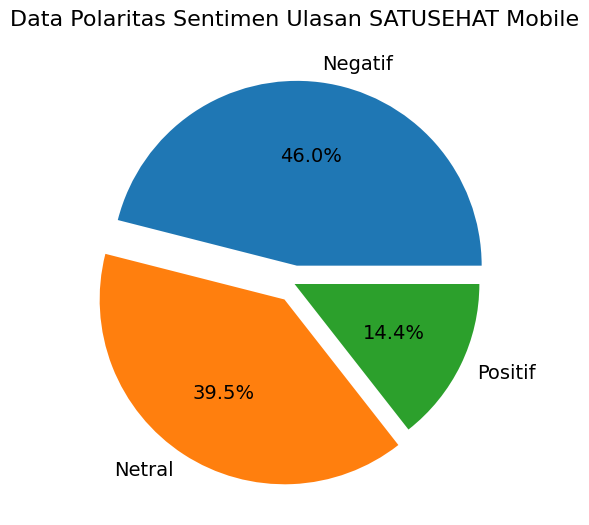

In [10]:
# Membuat objek gambar dan sumbu dengan ukuran (6, 6) inci.
fig, ax = plt.subplots(figsize=(6, 6))

# Mengambil jumlah data polaritas sentimen dari DataFrame 'review_df' dan menyimpannya dalam list 'sizes'.
sizes = [count for count in review_df['polarity'].value_counts()]

# Mengambil label atau kategori sentimen dari DataFrame 'review_df' dan menyimpannya dalam list 'labels'.
labels = list(review_df['polarity'].value_counts().index)

# Menentukan seberapa jauh potongan dari pie chart akan ditarik (0.1 artinya potongan pertama akan sedikit terpisah).
explode = [0.1 if i < 2 else 0 for i in range(len(sizes))]

# Membuat pie chart dengan data 'sizes', 'labels', dan 'explode' yang telah ditentukan.
# Autopct digunakan untuk menampilkan persentase di dalam setiap potongan pie.
# Textprops digunakan untuk mengatur ukuran font teks dalam pie chart.
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})

# Menetapkan judul untuk pie chart dengan ukuran font dan jarak (padding) tertentu.
ax.set_title('Data Polaritas Sentimen Ulasan SATUSEHAT Mobile', fontsize=16, pad=20)

# Menampilkan pie chart.
plt.show()

In [11]:
# Mengatur opsi tampilan Pandas agar kolom dapat menampilkan teks hingga 3000 karakter.
pd.set_option('display.max_colwidth', 3000)

# Membuat DataFrame baru 'positive_tweets' yang hanya berisi tweet dengan polaritas positif.
positive_tweets = review_df[review_df['polarity'] == 'Positif']

# Memilih hanya kolom-kolom tertentu dari DataFrame 'positive_tweets'.
positive_tweets = positive_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]

# Mengurutkan DataFrame 'positive_tweets' berdasarkan 'polarity_score' secara menurun.
positive_tweets = positive_tweets.sort_values(by='polarity_score', ascending=False)

# Mengatur ulang indeks DataFrame agar dimulai dari 0.
positive_tweets = positive_tweets.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
positive_tweets.index += 1

In [12]:
# Mengatur opsi tampilan Pandas agar kolom dapat menampilkan teks hingga 3000 karakter.
pd.set_option('display.max_colwidth', 3000)

# Membuat DataFrame baru 'neutral_tweets' yang hanya berisi tweet dengan polaritas negatif.
neutral_tweets = review_df[review_df['polarity'] == 'Netral']

# Memilih hanya kolom-kolom tertentu dari DataFrame 'neutral_tweets'.
neutral_tweets = neutral_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]

# Mengurutkan DataFrame 'neutral_tweets' berdasarkan 'polarity_score' secara menaik (ascending).
neutral_tweets = neutral_tweets.sort_values(by='polarity_score', ascending=False)

# Mengatur ulang indeks DataFrame agar dimulai dari 0.
neutral_tweets = neutral_tweets.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
neutral_tweets.index += 1

In [13]:
# Mengatur opsi tampilan Pandas agar kolom dapat menampilkan teks hingga 3000 karakter.
pd.set_option('display.max_colwidth', 3000)

# Membuat DataFrame baru 'negative_tweets' yang hanya berisi tweet dengan polaritas negatif.
negative_tweets = review_df[review_df['polarity'] == 'Negatif']

# Memilih hanya kolom-kolom tertentu dari DataFrame 'negative_tweets'.
negative_tweets = negative_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]

# Mengurutkan DataFrame 'negative_tweets' berdasarkan 'polarity_score' secara menaik (ascending).
negative_tweets = negative_tweets.sort_values(by='polarity_score', ascending=True)

# Memilih 10 baris pertama dari DataFrame yang sudah diurutkan.
negative_tweets = negative_tweets[0:10]

# Mengatur ulang indeks DataFrame agar dimulai dari 0.
negative_tweets = negative_tweets.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
negative_tweets.index += 1

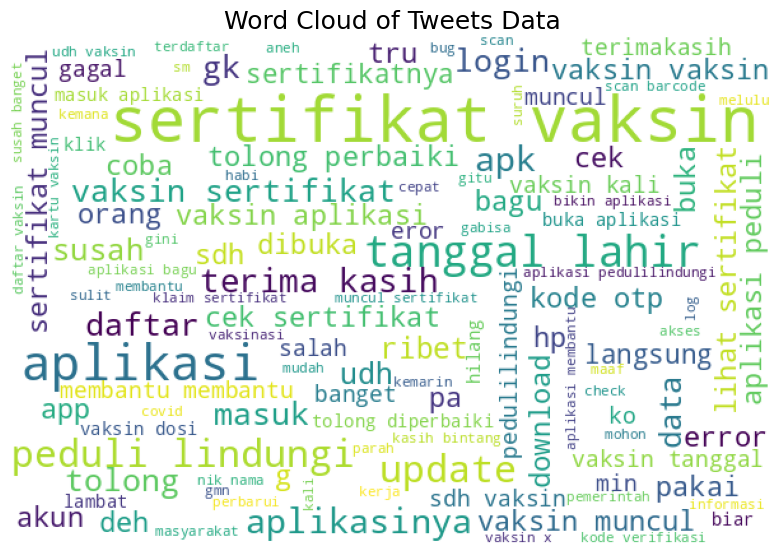

In [14]:
# Membuat string kosong 'list_words' yang akan digunakan untuk mengumpulkan semua kata dari teks yang sudah dibersihkan.
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'review_df'.
for tweet in review_df['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(8, 6))

# Menetapkan judul untuk word cloud.
ax.set_title('Word Cloud of Tweets Data', fontsize=18)

# Menonaktifkan grid pada sumbu.
ax.grid(False)

# Menampilkan word cloud dalam gambar.
ax.imshow((wordcloud))

# Mengatur layout gambar.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu.
ax.axis('off')

# Menampilkan word cloud.
plt.show()

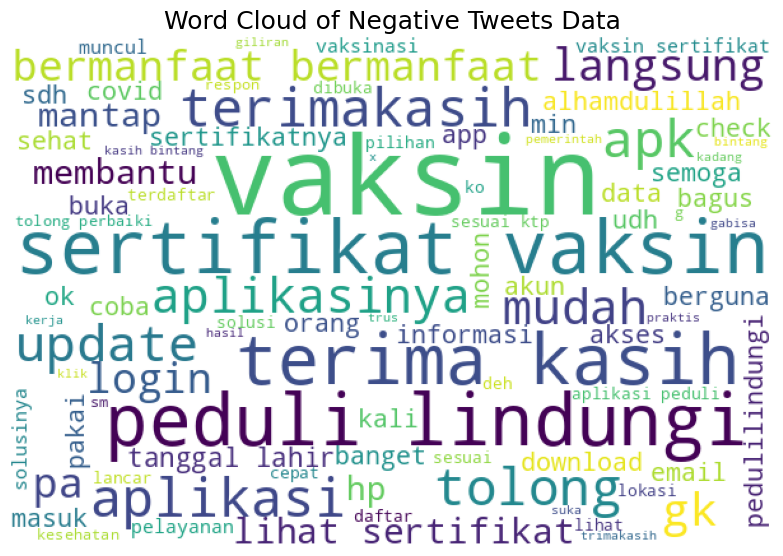

In [15]:
# Membuat string kosong 'list_words' yang akan digunakan untuk mengumpulkan semua kata dari teks yang sudah dibersihkan dalam tweet negatif.
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'positive_words'.
for tweet in positive_tweets['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(8, 6))

# Menetapkan judul untuk word cloud.
ax.set_title('Word Cloud of Negative Tweets Data', fontsize=18)

# Menonaktifkan grid pada sumbu.
ax.grid(False)

# Menampilkan word cloud dalam gambar.
ax.imshow((wordcloud))

# Mengatur layout gambar.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu.
ax.axis('off')

# Menampilkan word cloud.
plt.show()

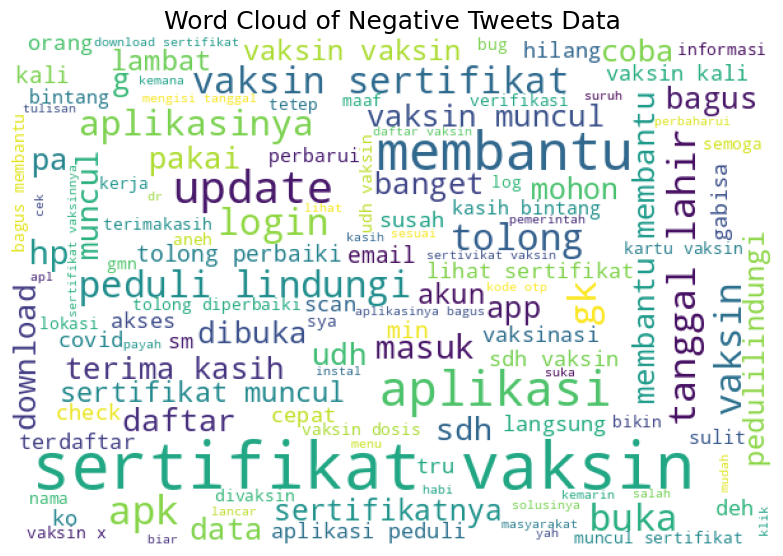

In [16]:
# Membuat string kosong 'list_words' yang akan digunakan untuk mengumpulkan semua kata dari teks yang sudah dibersihkan dalam tweet negatif.
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'neutral_tweets'.
for tweet in neutral_tweets['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(8, 6))

# Menetapkan judul untuk word cloud.
ax.set_title('Word Cloud of Negative Tweets Data', fontsize=18)

# Menonaktifkan grid pada sumbu.
ax.grid(False)

# Menampilkan word cloud dalam gambar.
ax.imshow((wordcloud))

# Mengatur layout gambar.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu.
ax.axis('off')

# Menampilkan word cloud.
plt.show()

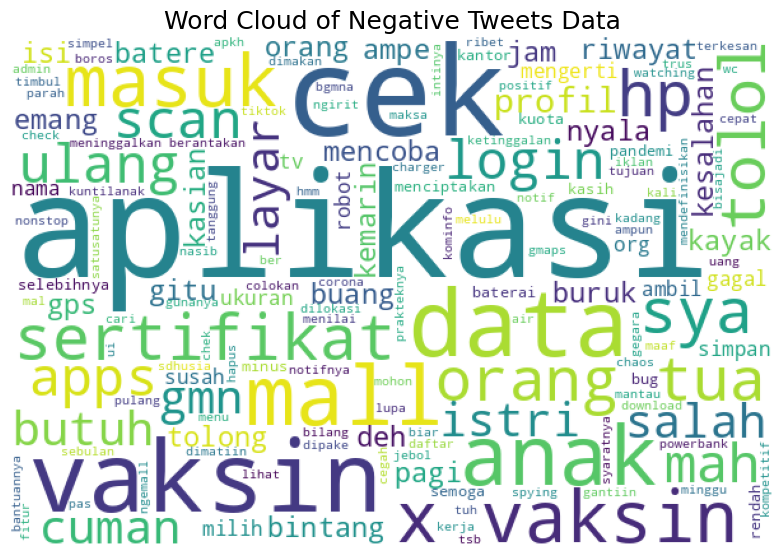

In [17]:
# Membuat string kosong 'list_words' yang akan digunakan untuk mengumpulkan semua kata dari teks yang sudah dibersihkan dalam tweet negatif.
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'negative_tweets'.
for tweet in negative_tweets['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(8, 6))

# Menetapkan judul untuk word cloud.
ax.set_title('Word Cloud of Negative Tweets Data', fontsize=18)

# Menonaktifkan grid pada sumbu.
ax.grid(False)

# Menampilkan word cloud dalam gambar.
ax.imshow((wordcloud))

# Mengatur layout gambar.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu.
ax.axis('off')

# Menampilkan word cloud.
plt.show()

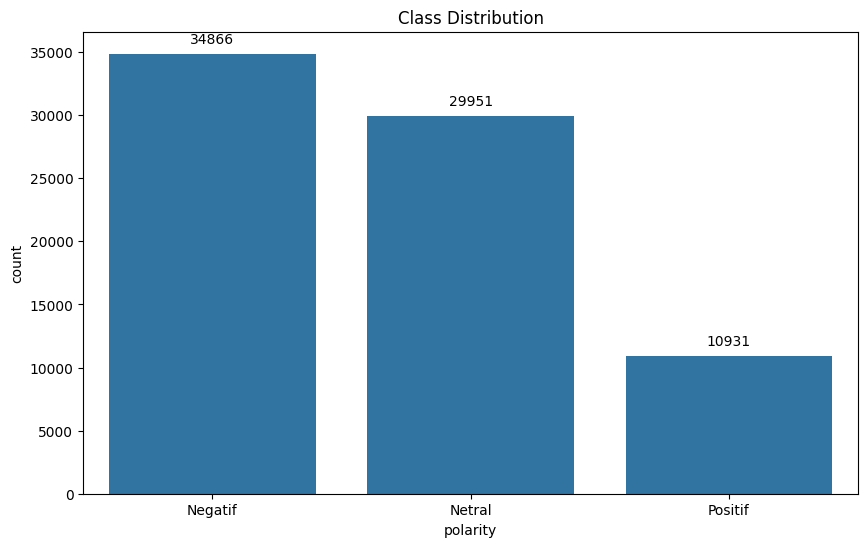

In [18]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Check class distribution
class_dist_plot = sns.countplot(x='polarity', data=review_df)
plt.title('Class Distribution')

# Add counts above the bars on the plot
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 10),
                              textcoords='offset points')

plt.show()

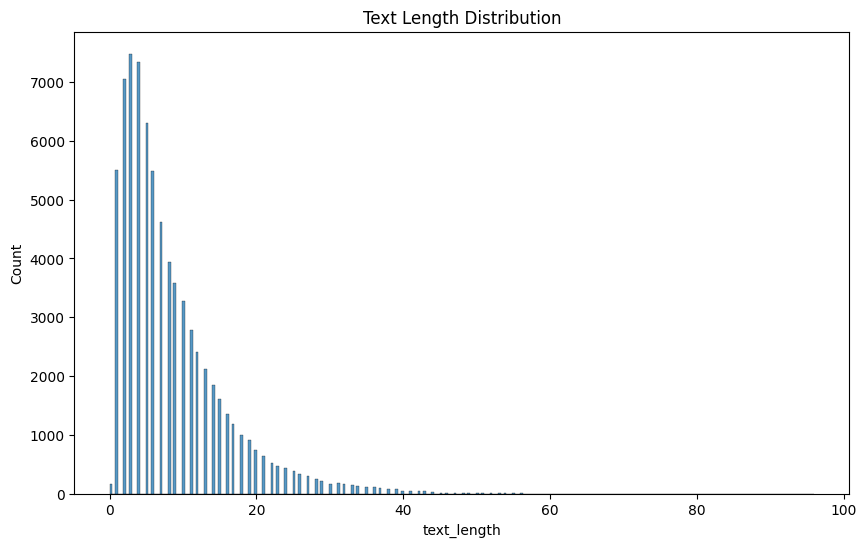

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [19]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Visualize text length distribution
review_df['text_length'] = review_df['text_akhir'].apply(lambda x: len(x.split()))
sns.histplot(review_df['text_length'])
plt.title('Text Length Distribution')
plt.show()

# Set the figure size
plt.figure(figsize=(12, 6))

In [20]:
review_df.head(2)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefolding_text,text_slangwords,text_tokenizing_text,text_stopword,text_akhir,polarity_score,polarity,text_length
0,ff4c68ed-46f2-4ac7-9a8f-a118226fbdda,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"Aplikasi gagal, mau login dipersulit, harusnya ada fitur lupa email/no telp, lalu cara memulihkan nya dengan cara memasukkan NIK, ini malah maksa suruh masukin email dan nomor telepon yang terdaftar, ya mana bisa tau orang udah lupa dan hilang, tolong lah developer nya gmna sih ini bikin aplikasinya, kalo bisa ngasih bintang -1 uda gw kasin mines ni aplikasi",1,194,7.5.0,2024-10-31 06:11:33,"Halo Healthies,\nTerima kasih telah meluangkan waktu untuk memberikan ulasan. Kami memahami dan mendengar kendala yang dialami di SATUSEHAT Mobile. Untuk itu kami ingin membantu menyelesaikan masalah ini. Silakan hubungi kami melalui https://link.kemkes.go.id/contactusSSM , agar kami dapat membantu penyelesaian kendala yang dihadapi. Terima kasih.",2024-10-31 06:12:29,7.5.0,Aplikasi gagal mau login dipersulit harusnya ada fitur lupa emailno telp lalu cara memulihkan nya dengan cara memasukkan NIK ini malah maksa suruh masukin email dan nomor telepon yang terdaftar ya mana bisa tau orang udah lupa dan hilang tolong lah developer nya gmna sih ini bikin aplikasinya kalo bisa ngasih bintang uda gw kasin mines ni aplikasi,aplikasi gagal mau login dipersulit harusnya ada fitur lupa emailno telp lalu cara memulihkan nya dengan cara memasukkan nik ini malah maksa suruh masukin email dan nomor telepon yang terdaftar ya mana bisa tau orang udah lupa dan hilang tolong lah developer nya gmna sih ini bikin aplikasinya kalo bisa ngasih bintang uda gw kasin mines ni aplikasi,aplikasi gagal mau login dipersulit harusnya ada fitur lupa emailno telepon lalu cara memulihkan nya dengan cara memasukkan nik ini bahkan maksa suruh masukkan email dan nomor telepon yang terdaftar iya mana bisa tahu orang sudah lupa dan hilang tolong lah developer nya gmna sih ini bikin aplikasinya kalau bisa memberikan bintang uda saya kasin mines ini aplikasi,"[aplikasi, gagal, mau, login, dipersulit, harusnya, ada, fitur, lupa, emailno, telepon, lalu, cara, memulihkan, nya, dengan, cara, memasukkan, nik, ini, bahkan, maksa, suruh, masukkan, email, dan, nomor, telepon, yang, terdaftar, iya, mana, bisa, tahu, orang, sudah, lupa, dan, hilang, tolong, lah, developer, nya, gmna, sih, ini, bikin, aplikasinya, kalau, bisa, memberikan, bintang, uda, saya, kasin, mines, ini, aplikasi]","[aplikasi, gagal, login, dipersulit, fitur, lupa, emailno, telepon, memulihkan, memasukkan, nik, maksa, suruh, masukkan, email, nomor, telepon, terdaftar, orang, lupa, hilang, tolong, developer, gmna, bikin, aplikasinya, bintang, uda, kasin, mines, aplikasi]",aplikasi gagal login dipersulit fitur lupa emailno telepon memulihkan memasukkan nik maksa suruh masukkan email nomor telepon terdaftar orang lupa hilang tolong developer gmna bikin aplikasinya bintang uda kasin mines aplikasi,-22,Negatif,31
1,86b5dd00-65eb-4595-8dec-eb083bb20099,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"Tidak bisa multi task,, kita buka gmail untuk melihat kode OTP, buka jendela satusehat sudah buka dari awal lagi,, masukkan email lagi,dpt kode OTP lagi,,sampai kiamat gak bisa log in,, kamu buat aplikasi sekolah sampai apa,,bodo dipelihara",1,4,7.7.0,2024-12-04 18:45:21,"Halo Healthies,\nTerima kasih telah meluangkan waktu untuk memberikan ulasan. Kami memahami dan mendengar kendala yang dialami di SATUSEHAT Mobile. Untuk itu kami ingin membantu menyelesaikan masalah ini. Silakan hubungi kami melalui https://link.kemkes.go.id/contactusSSM , agar kami dapat membantu penyelesaian kendala yang dihadapi. Terima kasih.",2024-12-

In [21]:
# Pisahkan data menjadi fitur (tweet) dan label (sentimen)
X = review_df['text_akhir']
y = review_df['polarity']

# Step 5: Kustomisasi Skema Pelatihan

## Skema 1: Word2Vec

In [22]:
# Tokenisasi text untuk Word2Vec
tokenized_data = [word_tokenize(sentence.lower()) for sentence in review_df['text_akhir']]

# Train model Word2Vec
word2vec_model = Word2Vec(sentences=tokenized_data, vector_size=300, window=5, min_count=5, workers=4)

In [23]:
# Membuat vektor-vektor fitur untuk setiap dokumen (rata-rata vektor-vektor kata)
def document_vector(doc):
    # Membuat vektor dokumen.
    doc_vectors = [word2vec_model.wv[word] for word in doc if word in word2vec_model.wv]
    return np.mean(doc_vectors, axis=0) if doc_vectors else np.zeros(word2vec_model.vector_size)

In [24]:
# Membuat vektor-vektor fitur dari semua dokumen
X_word2vec = np.array([document_vector(doc) for doc in tokenized_data])

In [25]:
# Bagi data menjadi data latih dan data uji
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_word2vec, y, test_size=0.2, random_state=42)

In [26]:
# Encode label string menjadi integer
label_encoder = LabelEncoder()
y_train_encoded_1 = label_encoder.fit_transform(y_train_1)  # Konversi menjadi [0, 1, 2]

# Assign bobot pada klasifikasi data yang imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded_1),
    y=y_train_encoded_1
)

class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict)

# Untuk BernoulliNB
class_prior = class_weights / class_weights.sum()
print("Class Priors:", class_prior)

# Untuk XGBoost
sample_weights = np.array([class_weight_dict[label] for label in y_train_encoded_1])
print("Sample Weights:", sample_weights)

Class Weights: {0: 0.7251079920067967, 1: 0.8440303080951586, 2: 2.2930336398380446}
Class Priors: [0.18774617 0.21853774 0.59371609]
Sample Weights: [0.72510799 2.29303364 0.72510799 ... 0.72510799 0.72510799 0.72510799]


### 1. Naive Bayes

In [27]:
# Membuat objek model Naive Bayes (Bernoulli Naive Bayes)
naive_bayes = BernoulliNB(class_prior=class_prior)

# Melatih model Naive Bayes pada data pelatihan
naive_bayes.fit(X_train_1, y_train_1)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_nb_1 = naive_bayes.predict(X_train_1)
y_pred_test_nb_1 = naive_bayes.predict(X_test_1)

# Evaluasi akurasi model Naive Bayes
accuracy_train_nb_1 = accuracy_score(y_pred_train_nb_1, y_train_1)
accuracy_test_nb_1 = accuracy_score(y_pred_test_nb_1, y_test_1)

# Menampilkan akurasi
print('Naive Bayes - accuracy_train:', accuracy_train_nb_1)
print('Naive Bayes - accuracy_test:', accuracy_test_nb_1)

Naive Bayes - accuracy_train: 0.5530050496716064
Naive Bayes - accuracy_test: 0.5508910891089109


### 2. Logistic Regression

In [28]:
# Membuat objek model Logistic Regression
logistic_regression = LogisticRegression(class_weight='balanced')

# Melatih model Logistic Regression pada data pelatihan
logistic_regression.fit(X_train_1, y_train_1)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr_1 = logistic_regression.predict(X_train_1)
y_pred_test_lr_1 = logistic_regression.predict(X_test_1)

# Evaluasi akurasi model Logistic Regression pada data pelatihan
accuracy_train_lr_1 = accuracy_score(y_pred_train_lr_1, y_train_1)

# Evaluasi akurasi model Logistic Regression pada data uji
accuracy_test_lr_1 = accuracy_score(y_pred_test_lr_1, y_test_1)

# Menampilkan akurasi
print('Logistic Regression - accuracy_train:', accuracy_train_lr_1)
print('Logistic Regression - accuracy_test:', accuracy_test_lr_1)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression - accuracy_train: 0.6734545694577379
Logistic Regression - accuracy_test: 0.6762376237623763


### 3. Decision Tree

In [29]:
# Membuat objek model Decision Tree
decision_tree = DecisionTreeClassifier(class_weight='balanced')

# Melatih model Decision Tree pada data pelatihan
decision_tree.fit(X_train_1, y_train_1)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_dt_1 = decision_tree.predict(X_train_1)
y_pred_test_dt_1 = decision_tree.predict(X_test_1)

# Evaluasi akurasi model Decision Tree
accuracy_train_dt_1 = accuracy_score(y_pred_train_dt_1, y_train_1)
accuracy_test_dt_1 = accuracy_score(y_pred_test_dt_1, y_test_1)

# Menampilkan akurasi
print('Decision Tree - accuracy_train:', accuracy_train_dt_1)
print('Decision Tree - accuracy_test:', accuracy_test_dt_1)

Decision Tree - accuracy_train: 0.9993399122083237
Decision Tree - accuracy_test: 0.644950495049505


### 4. Random Forest

In [30]:
# Membuat objek model Random Forest
random_forest = RandomForestClassifier(class_weight='balanced')

# Melatih model Random Forest pada data pelatihan
random_forest.fit(X_train_1, y_train_1)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf_1 = random_forest.predict(X_train_1)
y_pred_test_rf_1 = random_forest.predict(X_test_1)

# Evaluasi akurasi model Random Forest
accuracy_train_rf_1 = accuracy_score(y_pred_train_rf_1, y_train_1)
accuracy_test_rf_1 = accuracy_score(y_pred_test_rf_1, y_test_1)

# Menampilkan akurasi
print('Random Forest - accuracy_train:', accuracy_train_rf_1)
print('Random Forest - accuracy_test:', accuracy_test_rf_1)

Random Forest - accuracy_train: 0.9993564144031156
Random Forest - accuracy_test: 0.7456105610561056


### 5. XGBoost

In [31]:
y_test_encoded_1 = label_encoder.transform(y_test_1)       # Encode y_test_1

# Membuat objek model XGBoost
xgb_model = XGBClassifier(
    n_estimators=100,          # Jumlah tree
    max_depth=6,               # Maximal kedalaman tree
    learning_rate=0.1,         # Penyusutan ukuran langkah
    objective='multi:softmax', # Klasifikasi multikelas
    num_class=len(np.unique(y_train_encoded_1)), # Jumlah kelas
    random_state=42
)

# Melatih model XGBoost pada data pelatihan
xgb_model.fit(X_train_1, y_train_encoded_1, sample_weight=sample_weights)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_xgb_1 = xgb_model.predict(X_train_1)
y_pred_test_xgb_1 = xgb_model.predict(X_test_1)

# Evaluasi akurasi model Random Forest
accuracy_train_xgb_1 = accuracy_score(y_train_encoded_1, y_pred_train_xgb_1)
accuracy_test_xgb_1 = accuracy_score(y_test_encoded_1, y_pred_test_xgb_1)

# Print accuracy
print('XGBoost - accuracy_train:', accuracy_train_xgb_1)
print('XGBoost - accuracy_test:', accuracy_test_xgb_1)

XGBoost - accuracy_train: 0.7924683982969735
XGBoost - accuracy_test: 0.7274587458745875


## Skema 2 : TF-IDF

In [32]:
# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.7)
X_tfidf = tfidf.fit_transform(X)

In [33]:
# Bagi data menjadi data latih dan data uji
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [34]:
# Encode label string menjadi integer
label_encoder = LabelEncoder()
y_train_encoded_2 = label_encoder.fit_transform(y_train_2)  # Konversi menjadi [0, 1, 2]

# Assign bobot pada klasifikasi data yang imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded_2),
    y=y_train_encoded_2
)

class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict)

# Untuk BernoulliNB
class_prior = class_weights / class_weights.sum()
print("Class Priors:", class_prior)

# Untuk XGBoost
sample_weights = np.array([class_weight_dict[label] for label in y_train_encoded_2])
print("Sample Weights:", sample_weights)

Class Weights: {0: 0.7251079920067967, 1: 0.8440303080951586, 2: 2.2930336398380446}
Class Priors: [0.18774617 0.21853774 0.59371609]
Sample Weights: [0.72510799 2.29303364 0.72510799 ... 0.72510799 0.72510799 0.72510799]


### 1. Naive Bayes

In [35]:
# Membuat objek model Naive Bayes (Bernoulli Naive Bayes)
naive_bayes = BernoulliNB(class_prior=class_prior)

# Melatih model Naive Bayes pada data pelatihan
naive_bayes.fit(X_train_2.toarray(), y_train_2)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_nb_2 = naive_bayes.predict(X_train_2.toarray())
y_pred_test_nb_2 = naive_bayes.predict(X_test_2.toarray())

# Evaluasi akurasi model Naive Bayes
accuracy_train_nb_2 = accuracy_score(y_pred_train_nb_2, y_train_2)
accuracy_test_nb_2 = accuracy_score(y_pred_test_nb_2, y_test_2)

# Menampilkan akurasi
print('Naive Bayes - accuracy_train:', accuracy_train_nb_2)
print('Naive Bayes - accuracy_test:', accuracy_test_nb_2)

Naive Bayes - accuracy_train: 0.669873593187894
Naive Bayes - accuracy_test: 0.6637623762376238


### 2. Logistic Regression

In [36]:
# Membuat objek model Logistic Regression
logistic_regression = LogisticRegression(class_weight='balanced')

# Melatih model Logistic Regression pada data pelatihan
logistic_regression.fit(X_train_2.toarray(), y_train_2)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr_2 = logistic_regression.predict(X_train_2.toarray())
y_pred_test_lr_2 = logistic_regression.predict(X_test_2.toarray())

# Evaluasi akurasi model Logistic Regression pada data pelatihan
accuracy_train_lr_2 = accuracy_score(y_pred_train_lr_2, y_train_2)

# Evaluasi akurasi model Logistic Regression pada data uji
accuracy_test_lr_2 = accuracy_score(y_pred_test_lr_2, y_test_2)

# Menampilkan akurasi
print('Logistic Regression - accuracy_train:', accuracy_train_lr_2)
print('Logistic Regression - accuracy_test:', accuracy_test_lr_2)

Logistic Regression - accuracy_train: 0.8932803062807353
Logistic Regression - accuracy_test: 0.8858085808580858


### 3. Decision Tree

In [37]:
# Membuat objek model Decision Tree
decision_tree = DecisionTreeClassifier(class_weight='balanced')

# Melatih model Decision Tree pada data pelatihan
decision_tree.fit(X_train_2.toarray(), y_train_2)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_dt_2 = decision_tree.predict(X_train_2.toarray())
y_pred_test_dt_2 = decision_tree.predict(X_test_2.toarray())

# Evaluasi akurasi model Decision Tree
accuracy_train_dt_2 = accuracy_score(y_pred_train_dt_2, y_train_2)
accuracy_test_dt_2 = accuracy_score(y_pred_test_dt_2, y_test_2)

# Menampilkan akurasi
print('Decision Tree - accuracy_train:', accuracy_train_dt_2)
print('Decision Tree - accuracy_test:', accuracy_test_dt_2)

Decision Tree - accuracy_train: 0.9918644179675897
Decision Tree - accuracy_test: 0.7981518151815181


### 4. Random Forest

In [38]:
# Membuat objek model Random Forest
random_forest = RandomForestClassifier(class_weight='balanced')

# Melatih model Random Forest pada data pelatihan
random_forest.fit(X_train_2.toarray(), y_train_2)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf_2 = random_forest.predict(X_train_2.toarray())
y_pred_test_rf_2 = random_forest.predict(X_test_2.toarray())

# Evaluasi akurasi model Random Forest
accuracy_train_rf_2 = accuracy_score(y_pred_train_rf_2, y_train_2)
accuracy_test_rf_2 = accuracy_score(y_pred_test_rf_2, y_test_2)

# Menampilkan akurasi
print('Random Forest - accuracy_train:', accuracy_train_rf_2)
print('Random Forest - accuracy_test:', accuracy_test_rf_2)

Random Forest - accuracy_train: 0.9920129377207169
Random Forest - accuracy_test: 0.8416501650165017


### 5. XGBoost

In [39]:
y_test_encoded_2 = label_encoder.transform(y_test_2)       # Encode y_test_1

# Create and train the XGBoost model
xgb_model = XGBClassifier(
    n_estimators=100,          # Jumlah tree
    max_depth=6,               # Maximal kedalaman tree
    learning_rate=0.1,         # Penyusutan ukuran langkah
    objective='multi:softmax', # Klasifikasi multikelas
    num_class=len(np.unique(y_train_encoded_2)), # Jumlah kelas
    random_state=42
)

# Melatih model XGBoost pada data pelatihan
xgb_model.fit(X_train_2, y_train_encoded_2, sample_weight=sample_weights)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_xgb_2 = xgb_model.predict(X_train_2)
y_pred_test_xgb_2 = xgb_model.predict(X_test_2)

# Evaluasi akurasi model Random Forest
accuracy_train_xgb_2 = accuracy_score(y_train_encoded_2, y_pred_train_xgb_2)
accuracy_test_xgb_2 = accuracy_score(y_test_encoded_2, y_pred_test_xgb_2)

# Print accuracy
print('XGBoost - accuracy_train:', accuracy_train_xgb_2)
print('XGBoost - accuracy_test:', accuracy_test_xgb_2)

XGBoost - accuracy_train: 0.8085250338294994
XGBoost - accuracy_test: 0.7972937293729373


# Step 6: Evaluasi dan Prediksi

## Hasil Percobaan

In [40]:
# Membuat DataFrame untuk hasil akurasi
results_df = pd.DataFrame({
    'Skema': ["1 - Word2Vec", "1 - Word2Vec", "1 - Word2Vec", "1 - Word2Vec", "1 - Word2Vec",
              "2 - TF-IDF", "2 - TF-IDF", "2 - TF-IDF", "2 - TF-IDF", "2 - TF-IDF"],
    'Model': ['Naive Bayes', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost',
              'Naive Bayes', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'Accuracy Train': [accuracy_train_nb_1, accuracy_train_lr_1, accuracy_train_dt_1, accuracy_train_rf_1, accuracy_train_xgb_1,
                       accuracy_train_nb_2, accuracy_train_lr_2, accuracy_train_dt_2, accuracy_train_rf_2, accuracy_train_xgb_2],
    'Accuracy Test': [accuracy_test_nb_1, accuracy_test_lr_1, accuracy_test_dt_1, accuracy_test_rf_1, accuracy_test_xgb_1,
                      accuracy_test_nb_2, accuracy_test_lr_2, accuracy_test_dt_2, accuracy_test_rf_2, accuracy_test_xgb_2]
})

# Menampilkan hanya kolom "Accuracy Test"
print(results_df)

          Skema                Model  Accuracy Train  Accuracy Test
0  1 - Word2Vec          Naive Bayes        0.553005       0.550891
1  1 - Word2Vec  Logistic Regression        0.673455       0.676238
2  1 - Word2Vec        Decision Tree        0.999340       0.644950
3  1 - Word2Vec        Random Forest        0.999356       0.745611
4  1 - Word2Vec              XGBoost        0.792468       0.727459
5    2 - TF-IDF          Naive Bayes        0.669874       0.663762
6    2 - TF-IDF  Logistic Regression        0.893280       0.885809
7    2 - TF-IDF        Decision Tree        0.991864       0.798152
8    2 - TF-IDF        Random Forest        0.992013       0.841650
9    2 - TF-IDF              XGBoost        0.808525       0.797294


## Prediksi

In [50]:
# Input kalimat baru dari pengguna
kalimat_baru = input("Masukkan kalimat baru: ")

# Melakukan preprocessing pada kalimat baru
kalimat_baru_cleaned = cleaning_text(kalimat_baru)
kalimat_baru_casefolded = casefolding_text(kalimat_baru_cleaned)
kalimat_baru_slangfixed = fix_slangwords(kalimat_baru_casefolded)
kalimat_baru_tokenized = tokenizing_text(kalimat_baru_slangfixed)
kalimat_baru_filtered = filtering_text(kalimat_baru_tokenized)
kalimat_baru_final = to_sentence(kalimat_baru_filtered)

# Menggunakan objek tfidf yang sudah di-fit dari pelatihan sebelumnya
X_kalimat_baru = tfidf.transform([kalimat_baru_final])

# Memperoleh prediksi sentimen kalimat baru
prediksi_sentimen = logistic_regression.predict(X_kalimat_baru)

# Menampilkan hasil prediksi
if prediksi_sentimen[0] == 'Positif':
    print("Sentimen kalimat baru adalah POSITIF.")
elif prediksi_sentimen[0] == 'Netral':
    print("Sentimen kalimat baru adalah NETRAL.")
else:
    print("Sentimen kalimat baru adalah NEGATIF.")

Masukkan kalimat baru: UI nya cantik, aplikasinya membantu, fiturnya ok
Sentimen kalimat baru adalah POSITIF.
